# Part 2) Perform acceptance test

In this notebook, we show how we would accept or reject the spike train with the best match to a given spine response as a monosynaptic connection.

In general, the correlation R-value of the best-match spike train with a given spine response varies across recordings. This could be explained by the diversity of release probablities, noise levels, or the fact that the real presynaptic cell is not being recorded extracellularly. 

In order to gain insights what the distribution of R-value would be given these factors, we turn to surrogate methods.

After finding the best-match unit in a recordng, we simulate surrogate calcium traces as if there was a ground-truth monosynaptic connection between the best-match spike train and a *virtual spine*. In doing so, we also model a distribution of probability releases and we match the noise levels to the imaging data.
With all the simulated surrogate spine traces, we compute the surrogate distribution of R-values given the ground-truth monosynaptic connection (GT-Rs).

Next, we identify the unit with the second-best R-value from the correlation test in part 1 for the given spine and we simulate surrogate spine responses for this second best unit. Using our original best match unit spike train, we can compute an R-value distribution called test R-values (Test-Rs). This distribution tells us the R-values assuming that there is actually a monosynaptic connection between the second -best spike train and the given spine, but not from the the best match spike train.


We can finally compare the experimentally obtained R-value to the surrogate R-value distributions to answer the following questions:

- Does the experimentally obtained R-value reflects an actual monosynaptic connection?
- Could we observe the experimentally obtained R-value if there was a monosynaptic connection from another sorted unit, but not the best match?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import roiextractors as re
import matplotlib.pyplot as plt
from pathlib import Path
import quantities as pq
import seaborn as sns
from elephant.statistics import instantaneous_rate
from elephant import kernels
import scipy.signal as ss
import scipy.stats as stats
import scipy.ndimage as ndimg
from joblib import Parallel, delayed
from tqdm import tqdm
import sys

%matplotlib notebook

In [46]:
sys.path.append("..")
from imaging_tools import *

# 1. Simulate calcium spine responses from best match

## 1.1. Estimation of noise term from real images

What makes the calcium spine responses vary from the convolved presynaptic spike train? We first consider the noise. The level of measured noise from the imaging setup, which can be extracted from the imaging data. In our case, we model the noise as white noise, as in [Deneux et al. 2016](https://www.nature.com/articles/ncomms12190). 

In [6]:
# load saved output from part1 and example data for part2
saved_var = np.load('saved_data_P1.npz',allow_pickle=True)

spiketrains = saved_var['spiketrains']
best_match = saved_var['best_match']
second_match = saved_var['second_match']
best_r = saved_var['best_r']
individual_frs_ds_dff = saved_var['individual_frs_ds_dff']
keep_network_idxs = saved_var['keep']

In [7]:
nwb_file_path = "../notebooks/recB1_chip2282.nwb"
_, imag, _, _, mea_duration, ds_idxs = load_nwb_file(nwb_file_path)

<IPython.core.display.Javascript object>


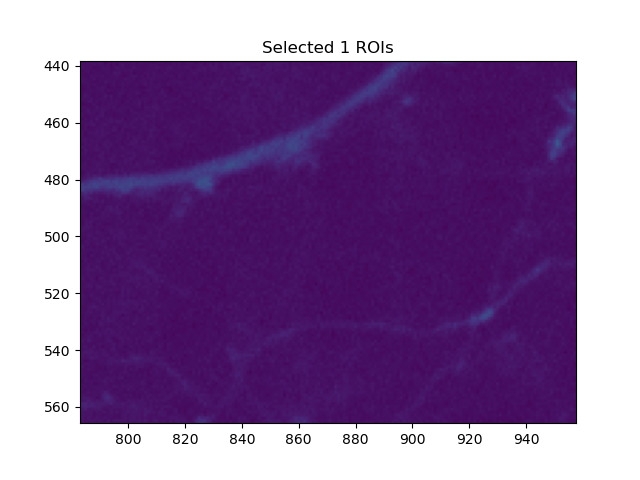

In [8]:
# extract noise from the real image
# randomly draw 1 roi from background without signal

avg_im = compute_avg_video(imag, stride=100)
rois_n = select_rois(avg_im)

<IPython.core.display.Javascript object>


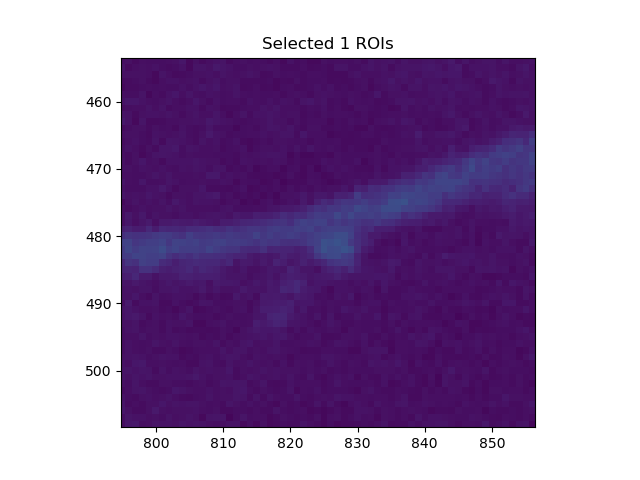

In [9]:
# extract spine ROI from the imaging
rois_s = select_rois(avg_im)

In [10]:
traces_n = extract_roi_activity(imag, rois_n[0], return_mean=False)
traces_s = extract_roi_activity(imag, rois_s[0], return_mean=False)
timestamps = np.linspace(0, mea_duration, imag.get_num_frames())

Extracting ROI of size 15: 100%|#########################################################| 1800/1800 [00:24<00:00, 74.82it/s]


<IPython.core.display.Javascript object>


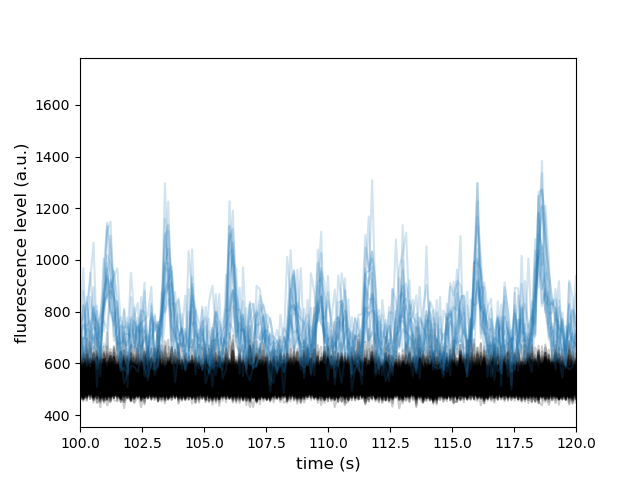

Text(0, 0.5, 'fluorescence level (a.u.)')

In [11]:
fig_ns, ax_ns = plt.subplots()
_ = ax_ns.plot(timestamps, traces_n.T, color="k", alpha=0.2)
_ = ax_ns.plot(timestamps, traces_s.T, color="C0", alpha=0.2)
ax_ns.set_xlim(100, 120)
ax_ns.set_xlabel("time (s)", fontsize=12)
ax_ns.set_ylabel("fluorescence level (a.u.)", fontsize=12)

In [12]:
n_pixels = np.min((len(traces_n),len(traces_s)))
idx_pixel = sorted(np.random.permutation(np.arange(len(traces_s)))[:np.int(np.ceil(n_pixels))])
std_noise = np.std(traces_n[idx_pixel], axis=1)
std_signal = np.std(traces_s, axis=1)

/var/folders/9s/_dykq12x0037_6qkncwzjvlh0000gp/T/ipykernel_13578/3962958012.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx_pixel = sorted(np.random.permutation(np.arange(len(traces_s)))[:np.int(np.ceil(n_pixels))])


<IPython.core.display.Javascript object>


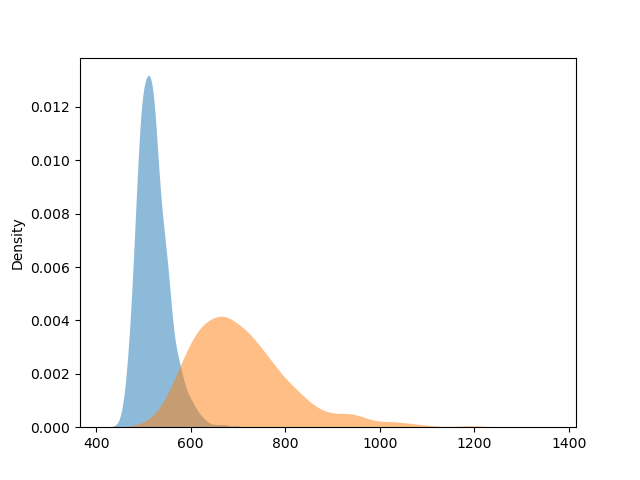

<AxesSubplot:ylabel='Density'>

In [13]:
plt.figure()
sns.kdeplot(
   traces_n[0],
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0)
sns.kdeplot(
   traces_s[0],
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0)

In [14]:
# We use the median of the medians of each signal pixel as baseline for the simulated trace
medians_signal = np.median(traces_s, 1)
baseline_signal = np.median(medians_signal) 

## 1.2. Release probablities

The second variable to be considered to simulate the calcium spine responses from a spike train is the release probablility. Here we use a set of random values following a log-normal distribution ($\mu$=2.5, $\sigma$=0.6) and scale by 0.01 as the release probability for simulation. 

<IPython.core.display.Javascript object>


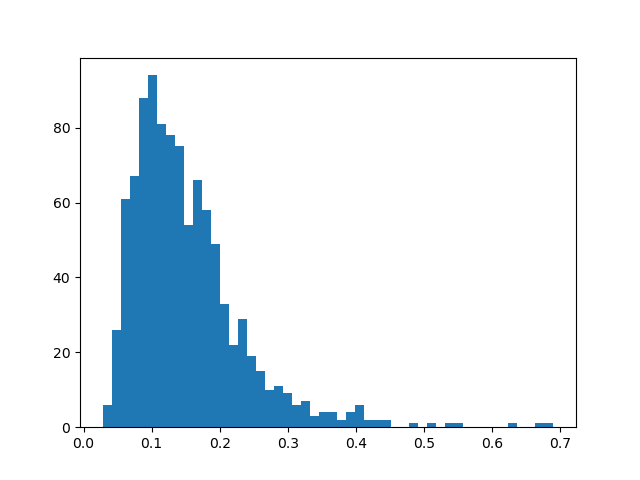

(array([ 6., 26., 61., 67., 88., 94., 81., 78., 75., 54., 66., 58., 49.,
        33., 22., 29., 19., 15., 10., 11.,  9.,  6.,  7.,  3.,  4.,  4.,
         2.,  4.,  6.,  2.,  2.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([0.02782837, 0.04107609, 0.05432382, 0.06757154, 0.08081926,
        0.09406698, 0.1073147 , 0.12056242, 0.13381014, 0.14705787,
        0.16030559, 0.17355331, 0.18680103, 0.20004875, 0.21329647,
        0.2265442 , 0.23979192, 0.25303964, 0.26628736, 0.27953508,
        0.2927828 , 0.30603052, 0.31927825, 0.33252597, 0.34577369,
        0.35902141, 0.37226913, 0.38551685, 0.39876457, 0.4120123 ,
        0.42526002, 0.43850774, 0.45175546, 0.46500318, 0.4782509 ,
        0.49149862, 0.50474635, 0.51799407, 0.53124179, 0.54448951,
        0.55773723, 0.57098495, 0.58423268, 0.5974804 , 0.61072812,
        0.62397584, 0.63722356, 0.65047128, 0.663719  , 0.67696673,
        0.69021445]),
 <BarContainer

In [34]:
# load release probability
release_probs = np.load('log_release_Pr.npy')

# optinal --> generate log-normally distributed release probability
# n_surrogates = 1000
# mean = 2.5
# sigma = 0.6

# release_probs = np.random.lognormal(mean,sigma,n_surrogates)/100
# release_probs[release_probs > 1] = np.random.random(len(release_probs[release_probs > 1]))
plt.figure()
plt.hist(release_probs, bins=50)

## 1.3. Simulation

To simulate the surrogate calcium spine responses, we first incorporate the simulated release probability with the spike trains, and convolve with the same kernel in part1 to get the simulated calcium traces of spike trains. Then, we add the whitenoise to the simulated calcium traces to get the more realistic simulation of spine calcium traces.

In [47]:
# Compute GT surrogates for the BT-match (method = 'GT_bm')
n_surrogates = 1000
PPRCTL = 25 
PLEN = 100

gt_surrogates = generate_surrogates(n_surrogates, imag.get_num_frames(), release_probs, spiketrains,best_match,
                                    ds_idxs, std_noise, std_signal, baseline_signal, PLEN, PPRCTL, method='GT_single')

Generating surrogates for single spike train: 100%|██████████████████████████████████████| 1000/1000 [07:32<00:00,  2.21it/s]


<IPython.core.display.Javascript object>


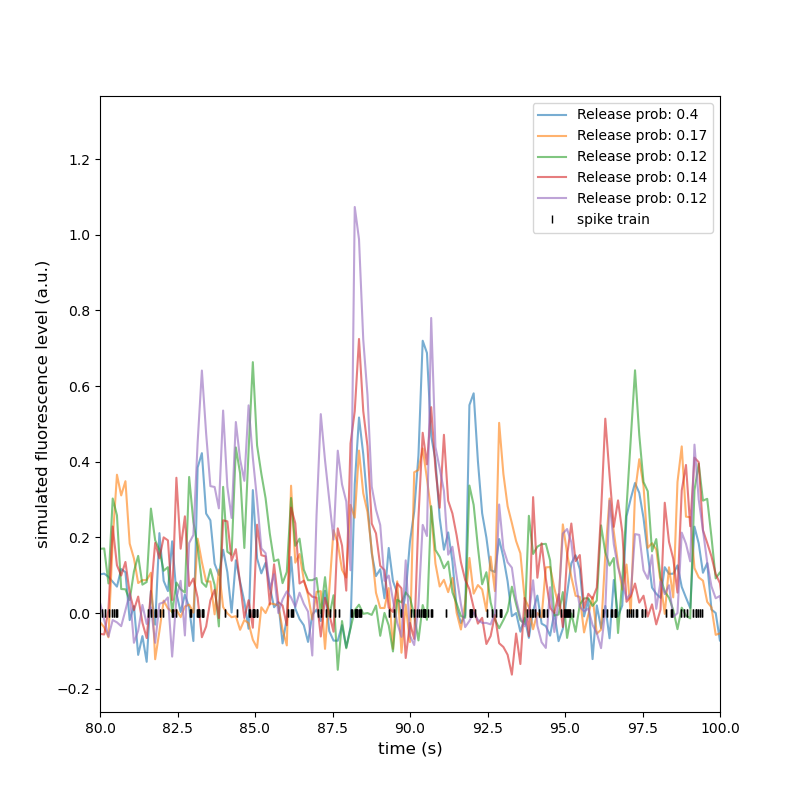

0.4020835195093964
0.17176585777437298
0.12040215980013395
0.14219239636543093
0.11569617197152418


In [48]:
fig_sim, ax_sim = plt.subplots(figsize=(8, 8))
# randomly draw 5 surrogate traces
surr_idxs = np.random.permutation(n_surrogates)[:5]
for surr_i in surr_idxs:
    print(release_probs[surr_i])
    ax_sim.plot(timestamps, gt_surrogates[surr_i], label=f"Release prob: {np.round(release_probs[surr_i], 2)}",
                alpha=0.6)
ax_sim.plot(spiketrains[best_match], np.zeros_like(spiketrains[best_match]), "k", marker="|", ls="")
ax_sim.set_xlabel("time (s)", fontsize=12)
ax_sim.set_ylabel("simulated fluorescence level (a.u.)", fontsize=12)
ax_sim.plot(spiketrains[best_match].times, np.zeros_like(spiketrains[best_match].times), '|', color='k',lw=0.1,
             label="spike train")
ax_sim.set_xlim(80, 100)
ax_sim.legend()

# 2.  Compute R-value distributions

## 2.1. GT-Rs

First, we compute the GT-Rs distribution, i.e. the distribution of R-values computed with the convolved best-match spike train and the surrogate spine traces computed in 1.3.

In [49]:
# Calculating correlation R-values to GT surrogates with all recorded spike trains
# to collect GT-Rs

GT_Rs = []
    
for k in range(n_surrogates):
    r, p = stats.pearsonr(gt_surrogates[k][keep_network_idxs], individual_frs_ds_dff[best_match][keep_network_idxs])
    GT_Rs.append(r)        
GT_Rs = np.array(GT_Rs)

## 2.2. Test-Rs 

Second, we compute the Test-Rs distribution, i.e. the distribution of R-values between the best-match spike train and surrogate spine traces simulated using the second best-match spike train.

In [50]:
# Compute test surrogates

test_surrogates = generate_surrogates(n_surrogates, imag.get_num_frames(), release_probs, spiketrains,
                                     second_match, ds_idxs, std_noise, std_signal, 
                                     baseline_signal, PLEN, PPRCTL, method='GT_single')

Generating surrogates for single spike train: 100%|██████████████████████████████████████| 1000/1000 [07:45<00:00,  2.15it/s]


In [51]:
test_Rs = []

for k in range(n_surrogates):
    r_second,p_second = stats.pearsonr(test_surrogates[k][keep_network_idxs], individual_frs_ds_dff[best_match][keep_network_idxs])
    test_Rs.append(r_second)
test_Rs = np.array(test_Rs)  

# 3. Acceptance based on Rs distributions

Based on the R-value distributions, we can define quantile thresholds to accept or reject an R-value as a monosynaptic connection.

In this case, we will accept the monosynaptic connection in case:

- the experimental R-value is above the 95th percentile of the Test-Rs distribution
- the experimental R-value is above the 10th percentile of the GT-Rs distribution

Test-threshold: 0.28800270499797487 - GT-threshold: 0.21382652056629156


<IPython.core.display.Javascript object>


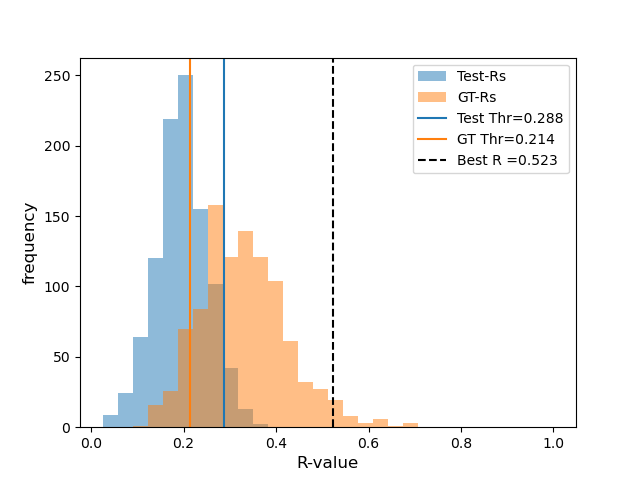

In [52]:
# Plot distributions of GT-Rs and test-Rs
test_threhsold = np.nanquantile(test_Rs, 0.95)
gt_threhsold = np.nanquantile(GT_Rs, 0.10)

print(f"Test-threshold: {test_threhsold} - GT-threshold: {gt_threhsold}")

fig_dist, ax_dist = plt.subplots()
ax_dist.hist(test_Rs, bins=30, range=(np.nanmin(test_Rs),1), alpha = 0.5, label = f'Test-Rs')
ax_dist.hist(GT_Rs, bins=30, range=(np.nanmin(test_Rs),1), alpha = 0.5, label = f'GT-Rs')
ax_dist.axvline(test_threhsold, color='C0', ls='-', label=f'Test Thr={np.round(test_threhsold, 3)}')
ax_dist.axvline(gt_threhsold, color='C1', ls='-', label=f'GT Thr={np.round(gt_threhsold, 3)}')
ax_dist.axvline(best_r, color='k', ls='--', label=f'Best R ={np.round(best_r, 3)}')
ax_dist.set_xlabel("R-value", fontsize=12)
ax_dist.set_ylabel("frequency", fontsize=12)
ax_dist.legend()

In [53]:
if best_r > max(test_threhsold, gt_threhsold):
    print('Accept the best match unit with the spine as a connection')
else:
    print('No presynaptic unit is mapped for the spine')

Accept the best match unit with the spine as a connection


# 4. Save data for next part

In the next notebook, we will use more surrogate methods to find the quantile thresholds that should be used for an optimal detection of monosynaptic connections.

In [55]:
np.savez('saved_data_P2.npz', release_probs=release_probs, std_noise=std_noise, std_signal=std_signal,baseline_signal=baseline_signal)